# Predict Masked Face or Not Masked Face

The purpose of this notebook is to detect masked or not masked faces from a provided image by using our trained neural network model. Make sure that the network weights are saved in `data/classifier_model_weights` folder. If you want to retrain the model, please refer `scripts/train_mask_nomask.ipynb` notebook. 

This notebook have an endpoint `predict_masked_faces` method to deploy this model in [dploy.ai](www.dploy.ai) platform. More details about this function is provided below.

## Import Libraries and Global Variables

In [1]:
import os

# Face Detector
import face_detection

# Python default libraries
from pathlib import Path
import time
import base64

# processing images
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

# visualising the data 
import matplotlib.pyplot as plt

# masked or not masked classification
import tensorflow as tf

# Max enabled image width is set as 300. If greater we will resize the input images 
BASEWIDTH = 600
MASKED_COLOR = '#00b189'
NOT_MASKED_COLOR = '#365abd'

ROOT_DIR = os.path.dirname(os.path.abspath(os.curdir))
FONT_TTF_LOC = str(Path(ROOT_DIR) / 'data' / 'fonts' / 'Arvo-Regular.ttf')

## Load Face Detection Model

The first stage of the model is detecting the faces from a given image. We used the `RetinaFace` face detector to extract faces as it is the state-of-the-art in face localisation in the wild, and works in real-time on a single CPU core.

In [2]:
face_detector = face_detection.build_detector('RetinaNetMobileNetV1',
                                              confidence_threshold=.5,
                                              nms_iou_threshold=.3)

### Helper Functions for Face Detection

In [3]:
def resize_image(img):
    # Resize image by keeping the aspect ratio if image witdth is greater than BASEWIDTH
    if img.size[0] > BASEWIDTH:
        wpercent = (BASEWIDTH / float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((BASEWIDTH,hsize), Image.ANTIALIAS)
    return img

def detect_face(resized_img):
    open_cv_image = np.array(resized_img) 
    open_cv_image = open_cv_image[:, :, ::-1].copy() # Convert BGR to RGB 
    return face_detector.detect(open_cv_image)

## Load Mask Classification Model

After detecting the faces, we crop the faces from the given image and run classifier model to predict whether a person wears a mask or not. 

In [4]:
classifier_dir = Path(ROOT_DIR) / 'data' / 'classifier_model_weights'
classifier = tf.keras.models.load_model(classifier_dir / 'best.h5')

### Helper Function for Mask Classification

In [5]:
def classify_faces(img_raw, face_coords):
    classification_scores = []
    # Iterate over detected face coordinates to find
    for coords in face_coords:
        x1, y1, x2, y2, _ = coords
        cropped_face = img_raw.crop((x1, y1, x2, y2))
        img = np.float32(cropped_face)
        img = cv2.resize(img, (112, 112)) 
        preprocessed_img = tf.keras.applications.mobilenet.preprocess_input(img)
        preprocessed_img = preprocessed_img[np.newaxis, ...]
        pred = classifier.predict_on_batch(preprocessed_img)[0][0]
        classification_scores.append(pred)
    return classification_scores

## Annotate Output Image  

To visualize our model, we annote the provided image. The detected faces are annotated with bounding boxes. The box has `light green` color if the detected face has a mask, otherwise it is `bluish purple`. The predicted class is written on top of the bounding box as `masked` or `not masked`. The score near the predicted class label represents the `sigmoid function` prediction score of the classification network's last layer. It is between `0` and `1`. If it is close to `1`, it means that the person more likely to has a `mask` on his/her face. Refer to the end of this notebook to see the annotated image example.

In [6]:
def annotate_image(img, face_coords, classified_face_scores, classification_labels):
    pil_draw = ImageDraw.Draw(img)
    for idx, coords in enumerate(face_coords):
        x1, y1, x2, y2, _ = coords
        label = classification_labels[idx]
        color = MASKED_COLOR if label == 'masked' else NOT_MASKED_COLOR
        display_str = "{}: {:.2f}".format(label, classified_face_scores[idx])

        # Draw rectangle for detected face
        pil_draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Draw label text box
        # portion of image width you want text width to be
        img_fraction = 0.2
        font_size = 5  # starting font size
        
        font = ImageFont.truetype(FONT_TTF_LOC, font_size)
        image_size = img.size[0]
        
        while font.getsize(display_str)[0] < img_fraction * image_size:
            # iterate until the text size is just larger than the criteria
            font_size += 1
            font = ImageFont.truetype(FONT_TTF_LOC, font_size)

        # Find coordinates of bounding text box
        w, h = font.getsize(display_str)
        pil_draw.rectangle([x1, y1, x1 + w, y1 + h], fill=color)
        pil_draw.text((x1, y1), display_str, font=font)
    return img

def convert_pil_to_base64(annotated_image, image_type):
    buffered = BytesIO()
    if image_type == 'jpg':
        annotated_image.save(buffered, format='jpeg')
    elif image_type == 'png':
        annotated_image.save(buffered, format='png')
    else:
        annotated_image.save(buffered, format=image_type)
    annotated_image_base64 = base64.b64encode(buffered.getvalue())
    return annotated_image_base64.decode('utf-8')

## Endpoint Function To Deploy our Model in Dploy.ai

`Dploy.ai` provides a very easy endpoint annotation. By typing `# @dploy endpoint`, we are telling `dploy.ai` that when our model is deployed, the API will use this function. `body` argument will be the posted dictionary via the API and the return dictionary will be the api response. 
```
{
 image: <Base64 Image String>,
 type: <Image Type e.g. jpg, jpeg, png>
}
```
and the response dictionary will be 
```
{
    'detected_face_coordinates': <the bounding box coordinates of the detected faces e.g. 
                                 [[x1, y1, x2, y2], [x1, y1, x2, y2]]>,
    'detected_mask_scores': <the prediction score of the detected faces between 0 and 1 e.g.
                            ["0.8", "0.99", "0.001"]>,
    'detected_face_labels': <human readible classification results of the detected faces e.g.
                            [masked, masked, not masked]>,
    'annotated_image': <annotated base64 image that visualizes the prediction results with  
                       bounding boxes and text labels>,
    'image_type': <Image Type e.g. jpg, jpeg, png>
}
```

In [7]:
# @dploy endpoint
def predict_masked_faces(body):
    base64_image = body['image'].encode('utf-8')
    image_type = body['type']
    
    # Convert image from base64 to PIL Image and resize it to improve the performance
    img_raw = Image.open(BytesIO(base64.b64decode(base64_image)))
    
    # Resize image
    resized_img = resize_image(img_raw)
    
    # Detect face coordinates from the raw image
    face_coords = detect_face(resized_img)
    
    # Classify detected faces whether they have a mask or not
    classified_face_scores = classify_faces(resized_img, face_coords)
    
    # Find labels
    classification_labels = np.where(np.array(classified_face_scores) > 0.5, 'masked', 'not masked').tolist()
    
    # Annotate base image with detected faces and mask classification
    annotated_image = annotate_image(resized_img, face_coords, classified_face_scores, classification_labels)
    
    # Convert PIL image to base64
    annotated_image_base_64 = convert_pil_to_base64(annotated_image, image_type)
    
    # Convert score to string type to make it serializable
    classified_face_scores = [float(score) for score in classified_face_scores] 
    
    return {
            'detected_face_coordinates': face_coords.tolist(),
            'detected_mask_scores': classified_face_scores,
            'detected_face_labels': classification_labels,
            'annotated_image': annotated_image_base_64,
            'image_type': image_type
           }

## Test Entire Pipeline with Dploy Endpoint Function

Test function to run entire pipeline. 

2.485272169113159


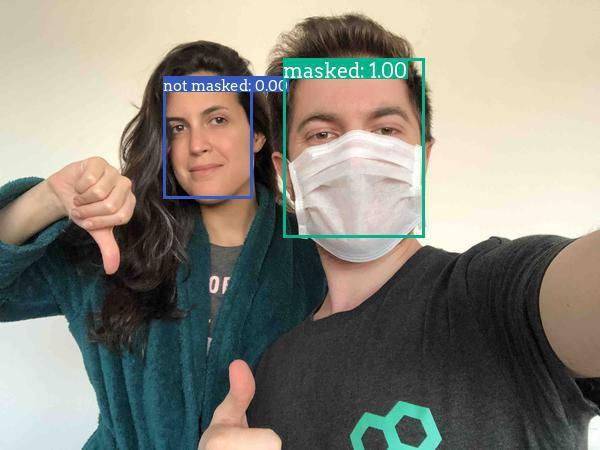

In [8]:
import json
path = os.path.join('img', 'ex_img.jpg')
with open(path, 'rb') as img_file:
    # We need to convert jpeg image into base64 string image to serialize the image.
    body = {
        'image': base64.b64encode(img_file.read()).decode('utf-8'),
        'type': 'jpg'
    }
    _time = time.time()
    response = predict_masked_faces(body)
    print(str(time.time() - _time))
# Show Annotated Image to give an idea what model prediction looks like
img = Image.open(BytesIO(base64.b64decode(response['annotated_image'])))
img.save(os.path.join('img', 'ex_img_annotated.jpg'))
img